In [2]:
using Distributions, Random, Plots, CurveFit, LinearAlgebra, Richardson, SpecialFunctions
Random.seed!(123)

TaskLocalRNG()

In [3]:
global const diffusivity = 1.00::Float64

global const endtime = 1.00::Float64
global const L = 1.00::Float64

global const dt = 1e-4::Float64
global const timesteps = Int64(div(endtime,dt)+1)::Int64

global const spacesteps = 150::Int64

global const u0_tilda = 1::Int64
global const u0 = (u0_tilda*spacesteps/L)::Float64

global const cfl = (diffusivity*(spacesteps*spacesteps)*dt/L^2)::Float64

##########################################################################

global const D_left = 20.00::Float64
global const D_right = 1.00::Float64





1.0

### Diffusion equation 
$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( D\frac{\partial u}{\partial x}\right)$$

In [4]:
function Crank_Nicolson_step(A::Tridiagonal{Float64, Vector{Float64}}, B::Tridiagonal{Float64, Vector{Float64}}, u_inint::Vector{Float64})
    return A\(B*u_inint)
end

function CN_absorbing_BC(u_init::Vector{Float64}, alpha::Float64)
    #A * U_n+1 = B * U_n
    n_steps = spacesteps-2

    A = Tridiagonal(fill(-alpha/2, n_steps-1),
                    fill(1+alpha, n_steps),
                    fill(-alpha/2, n_steps-1))

    B = Tridiagonal(fill(alpha/2, n_steps-1),
                    fill(1-alpha, n_steps),
                    fill(alpha/2, n_steps-1))


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[n][2:end-1]),0])
    end
    return res
end 

function CN_reflecting_BC(u_init::Vector{Float64}, alpha::Float64)
    #A * U_n+1 = B * U_n
    n_steps = size(u_init,1)

    A = Tridiagonal(reduce(vcat, [fill(-alpha/2, n_steps-2), -alpha]),
                        fill(1+alpha, n_steps),
                        reduce(vcat, [-alpha, fill(-alpha/2, n_steps-2)]))
    
    B = Tridiagonal(reduce(vcat, [fill(alpha/2, n_steps-2), alpha]),
                        fill(1-alpha, n_steps),
                        reduce(vcat, [alpha, fill(alpha/2, n_steps-2)]))

    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = Crank_Nicolson_step(A,B,res[n])
    end
    return res
end



CN_reflecting_BC (generic function with 1 method)

In [5]:
function absorbing_bounds(x0::Float64, x::Float64, t::Float64; max_iter = 1000, tol = 1e-8)
    res = 0
    term = 1 
    for n in 1:max_iter
        vn_x0 = sqrt(2/L) * sin(n * pi * x0/L)
        vn_x = sqrt(2/L) * sin(n * pi * x/L)
        term = exp(-((n * pi/L)^2) * diffusivity * t) * vn_x0 * vn_x
        res += term
        if tol > abs(term) && abs(term) > 1e-15
            break
        end
    end
    return u0_tilda * res
end

function reflecting_bounds(x0::Float64, x::Float64, t::Float64; max_iter = 1000, tol = 1e-8)
    res = 1/L
    term = 1 
    for n in 1:max_iter
        vn_x0 = sqrt(2/L) * cos(n * pi * x0/L)
        vn_x = sqrt(2/L) * cos(n * pi * x/L)
        term = exp(-((n * pi/L)^2) * diffusivity * t) * vn_x0 * vn_x
        res += term
        if tol > abs(term) && abs(term) > 1e-15
            break
        end
    end
    return u0_tilda * res
end

function unbounded(x0::Float64, x::Float64, t::Float64)
    return u0_tilda/sqrt(4 * pi * diffusivity * t) * exp(-(x-x0)^2/(4* diffusivity * t))
end

unbounded (generic function with 1 method)

In [6]:
function plot_array(vals_CN, vals_an, time_arr, x)
    plt = plot()
    for time in time_arr
        scatter!(x,vals_CN[round(Int, time/dt),:], label = t[round(Int, time/dt)])
        plot!(x,vals_an[round(Int, time/dt),:], color = "black", label = "")#t[round(Int, time/dt)])
    end
    scatter!(x,vals_CN[end,:], label = t[end])
    plot!(x,vals_an[end,:], color = "black", label = "")#t[round(Int, time/dt)])
    return plt 
end



plot_array (generic function with 1 method)

In [7]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2


u_res_absorbing = CN_absorbing_BC(u_init, cfl)

u_res_reflecting = CN_reflecting_BC(u_init, cfl)

u_an_unbounded = unbounded.(L/2, x', t[2:end])

# u_an_absorbing = absorbing_bounds.(L/2, x', t)

# u_an_reflecting= reflecting_bounds.(L/2, x', t)

println("Done")

Done


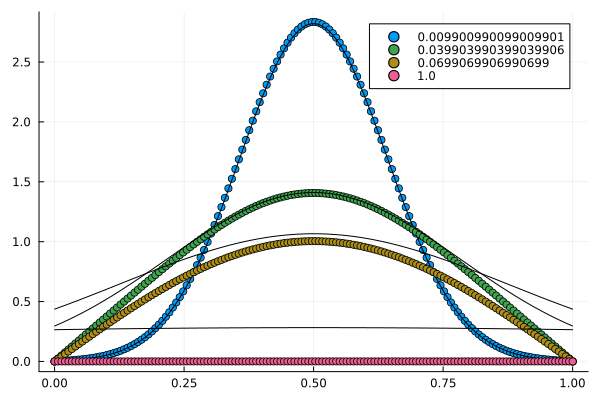

In [8]:
plot_array(u_res_absorbing, u_an_unbounded, [0.01,0.04,0.07],x )


In [9]:
plot_array(u_res_reflecting, u_an_unbounded, [0.01,0.04,0.07],x )
println(sum(u_res_reflecting[round(Int, 1/dt)]*L/spacesteps))

1.006711409396972


In [10]:
# plot_array(u_res_absorbing, u_an_absorbing, [0.01,0.04,0.07],x )

In [11]:
# plot_array(u_res_reflecting, u_an_reflecting, [0.01,0.04,0.07],x )

In [12]:
function left_or_right(x,x_boundary)
    if x < x_boundary
        return true
    else x >= x_boundary
        return false
    end
end

function step_diffusivity(x::Float64,x_boundary::Float64)
    
    if left_or_right(x,x_boundary)
        return D_left*dt*spacesteps^2/L^2
    else left_or_right(x,x_boundary)
        return D_right*dt*spacesteps^2/L^2
    end
end

function make_diagonals(alpha::Vector{Float64}; method ='a')
    
    if method == 'a'
        n_steps = spacesteps-2
        
        LDA = zeros(n_steps-1) - (alpha[2:end-2] + alpha[3:end-1])/4
        MDA = ones(n_steps) + (alpha[1:end-2] + 2*alpha[2:end-1] + alpha[3:end])/4
        UDA = zeros(n_steps-1) - (alpha[2:end-2] + alpha[3:end-1])/4

        LDB = zeros(n_steps-1) + (alpha[2:end-2] + alpha[3:end-1])/4
        MDB = ones(n_steps) - (alpha[1:end-2] + 2*alpha[2:end-1] + alpha[3:end])/4
        UDB = zeros(n_steps-1) + (alpha[2:end-2] + alpha[3:end-1])/4

        # LDB = zeros(n_steps-1) + alpha[2:end-2]/4
        # MDB = -ones(n_steps) + alpha[2:end-1]/4
        # UDB = zeros(n_steps-1) + alpha[3:end-1]/4
    end

    if method == 'r'
        n_steps = spacesteps
        left_imaginary = reduce(vcat, [alpha[1], alpha[1:end-1]])
        right_imaginary =reduce(vcat, [alpha[2:end], alpha[end]])
        reduce(vcat, [alpha[2:end]/2, alpha[end-1]/2])
        LDA = zeros(n_steps-1) - (alpha[1:end-1] + alpha[2:end])/4
        MDA = ones(n_steps) + (left_imaginary + 2*alpha + right_imaginary)/4
        UDA = zeros(n_steps-1) - (alpha[1:end-1] + alpha[2:end])/4

        LDB = zeros(n_steps-1) + (alpha[1:end-1] + alpha[2:end])/4
        MDB = ones(n_steps) - (left_imaginary + 2*alpha + right_imaginary)/4
        UDB = zeros(n_steps-1) + (alpha[1:end-1] + alpha[2:end])/4

        LDA[end]+= -(alpha[end] + alpha[end-1])/4
        UDA[1]  += -(alpha[1] + alpha[2])/4

        LDB[end]+= (alpha[end] + alpha[end-1])/4
        UDB[1]  += (alpha[1] + alpha[2])/4

    end

    return LDA, MDA, UDA, LDB, MDB, UDB
end

function absorbing_step(u_init::Vector{Float64}, alphas::Vector{Float64})

    n_steps = spacesteps - 2
   
    LDA, MDA, UDA, LDB, MDB, UDB = make_diagonals(alphas)
    
    A = Tridiagonal(LDA, MDA, UDA)

    B = Tridiagonal(LDB, MDB, UDB)


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[n][2:end-1]),0])
    end
    return res
end 

function reflecting_step(u_init::Vector{Float64}, alphas::Vector{Float64})
    #A * U_n+1 = B * U_n
    n_steps = spacesteps
   
    LDA, MDA, UDA, LDB, MDB, UDB = make_diagonals(alphas; method = 'r')
    
    A = Tridiagonal(LDA, MDA, UDA)

    B = Tridiagonal(LDB, MDB, UDB)


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = Crank_Nicolson_step(A,B,res[i-1])
    end
    return res
end



reflecting_step (generic function with 1 method)

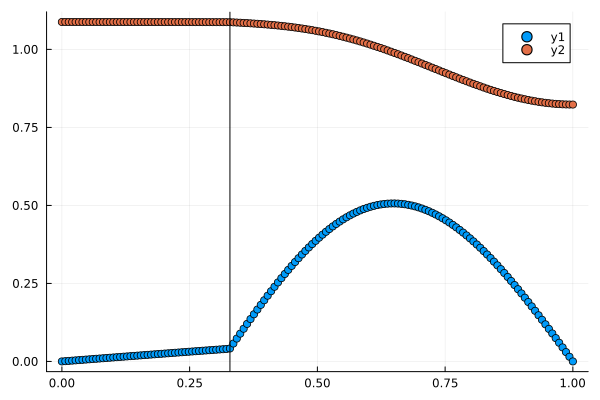

In [13]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)

u_init[div(spacesteps, 2)] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2
x_boundary = x[div(spacesteps, 3)]

alphas = step_diffusivity.(x,x_boundary)

absorbing_variable_D = absorbing_step(u_init, alphas)
reflecting_variable_D = reflecting_step(u_init, alphas)

plot(scatter(x,absorbing_variable_D[round(Int, 0.07/dt)]))
plot(scatter!(x,reflecting_variable_D[round(Int, 0.07/dt)]))
vline!([x_boundary],color ="black", label="")





In [14]:

function A_prefix_r(t, x0, x_boundary)

    erf_right = erf(x0 / sqrt(4*D_right*t))-1
    erf_left = erf(x0 / sqrt(4*D_left*t))-1

    exponent = (D_right - D_left)*(x0)^2/(4*D_right*D_left*t)
    
    denominator = 1 + erf_right + sqrt(D_left/D_right) * exp(exponent) * (1-erf_left)
    return 1/denominator
end

function A_prefix_l(t, x0, x_boundary)


    exponent = (D_right - D_left)*(x0)^2/(4*D_right*D_left*t)

    return A_prefix_r(t, x0, x_boundary)*sqrt(D_left/D_right)*exp(exponent)
    
end

function u_an_step_D(x, t, x0, x_boundary)
    # if t == 0 return 0 end
    if left_or_right(x,x_boundary)
        return u0_tilda*A_prefix_l(t, x0, x_boundary)*exp(-(x-x0)^2/(4*D_left*t))/sqrt(4*pi*D_left*t)
    else
        return u0_tilda*A_prefix_r(t, x0, x_boundary)*exp(-(x-x0)^2/(4*D_right*t))/sqrt(4*pi*D_right*t)
    end
    
end




u_an_step_D (generic function with 1 method)

In [15]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2

x0 = 0.5

x_boundary = x[end-div(spacesteps, 2)+30]

res = u_an_step_D.(x', t, x0, x_boundary)

alphas = step_diffusivity.(x,x_boundary)
absorbing_variable_D = absorbing_step(u_init, alphas)
reflecting_variable_D = reflecting_step(u_init, alphas)

plot(scatter(x,absorbing_variable_D[round(Int, 1/dt)]))
plot(scatter!(x,reflecting_variable_D[round(Int, 1/dt)]))
plot!(x,res[round(Int, 1/dt),:])

vline!([x_boundary],color ="black", label="")

println(sum(reflecting_variable_D[end]*(L/spacesteps)))



1.0067114093982494


In [39]:
function quadratic_func(x::Float64; C = 1.00)
    return (C*(x-1)^2 + (x-1) + 2)
end

function cubic_func(x::Float64; C = 1.00)
    return (C*(x-1)^3 + (x-1)^2 + (x-1) + 2)
end

function linear_func(x::Float64; C = 1.00)
    return C*x + 1
end

function variable_diffusivity(f, x; C = 1.00)
    return f.(x;C)
end




variable_diffusivity (generic function with 1 method)

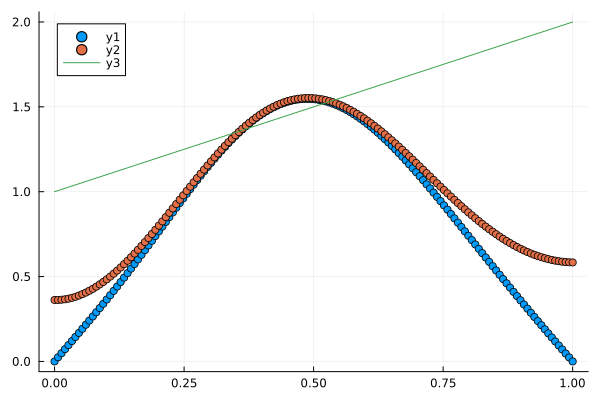

In [41]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)+0] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2

alphas = variable_diffusivity(linear_func, x)

absorbing_variable_D = absorbing_step(u_init, alphas)
reflecting_variable_D = reflecting_step(u_init, alphas)

plot(scatter(x,absorbing_variable_D[round(Int, 0.05/dt)]))
plot(scatter!(x,reflecting_variable_D[round(Int, 0.05/dt)]))

plot!(x,linear_func.(x))
